# 5. Advanced Gradient Descent Optimizers - AdaGrad, RMSProp and Adam

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### The problem with Vanilla GD

Let us start this notebook by discussing the typical issue with the Vanilla Gradient Descent.

To demonstrate, we will define an objective function, $ f $, below:

$$ f(x) = \frac{319}{8400} x^4 + \frac{43}{4200} x^3 - \frac{6799}{8400} x^2 - \frac{299}{840} x + 6 $$

And its derivative $ f' $:

$$ f'(x) = \frac{1276}{8400} x^3 + \frac{129}{4200} x^2 - \frac{13598}{8400} x - \frac{299}{840} $$

We implement them below as **obj_fun()** and **obj_fun_deriv()**.

In [2]:
def obj_fun(val):
    a4 = 319/8400
    a3 = 43/4200
    a2 = -6799/8400
    a1 = -299/840
    a0 = 6
    return a4*val**4 + a3*val**3 + a2*val**2 + a1*val + a0

In [3]:
def obj_fun_deriv(val):
    a4 = 319/8400
    a3 = 43/4200
    a2 = -6799/8400
    a1 = -299/840
    return 4*a4*val**3 + 3*a3*val**2 + 2*a2*val + a1

This objective function we chose on purpose, as it possess two minimum: a local non-global one around -3.254993730859254, and a global one around 3.2727653395584366. We can visualize them below.

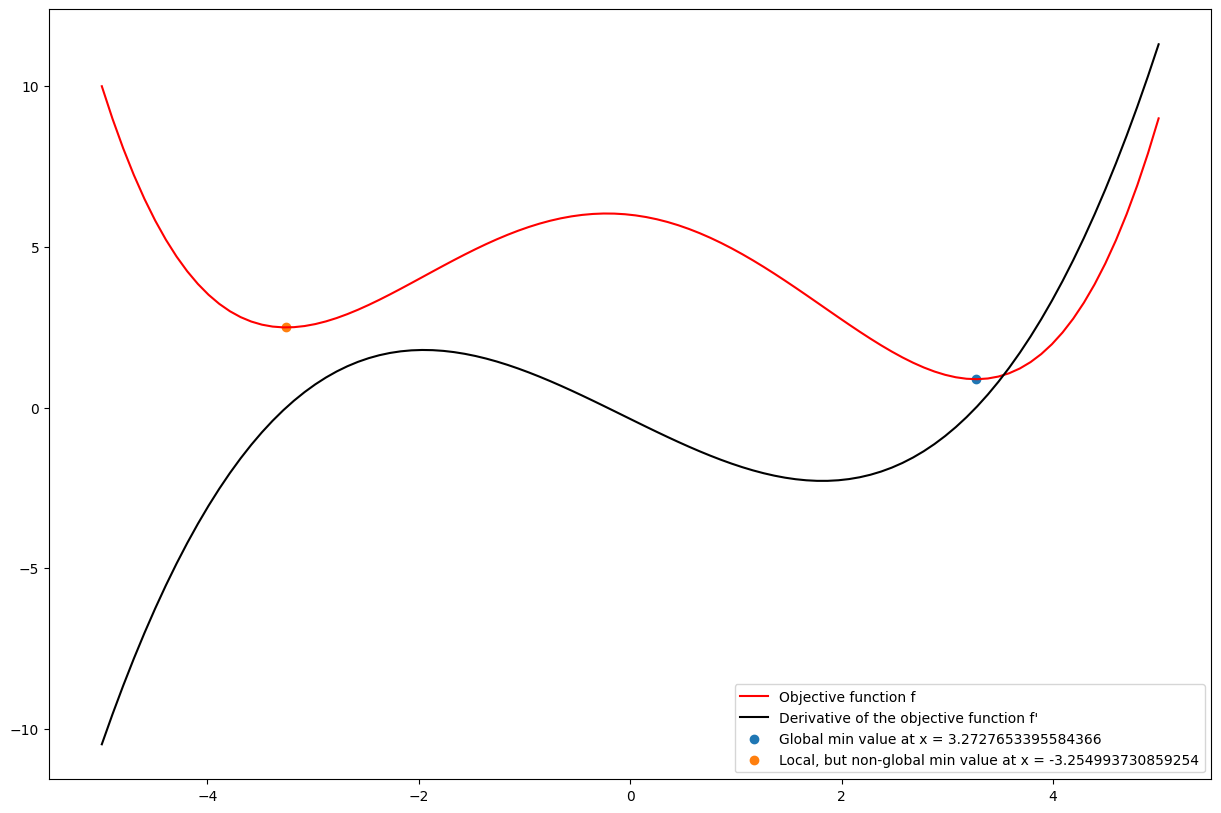

In [4]:
plt.figure(figsize = (15, 10))
x = np.linspace(-5, 5, 100)
y = [obj_fun(i) for i in x]
yp = [obj_fun_deriv(i) for i in x]
plt.plot(x, y, "r", label = "Objective function f")
plt.plot(x, yp, "k", label = "Derivative of the objective function f'")
approx_min_x = 3.2727653395584366
min_y = obj_fun(approx_min_x)
plt.scatter(approx_min_x, min_y, label = "Global min value at x = {}".format(approx_min_x))
approx_min_x2 = -3.254993730859254
min_y2 = obj_fun(approx_min_x2)
plt.scatter(approx_min_x2, min_y2, label = "Local, but non-global min value at x = {}".format(approx_min_x2))
plt.legend(loc = "best")
plt.show()

Below, we implement a typical vanilla gradient descent, in the **vanilla_gd()** function below.

In [5]:
def vanilla_gd(start_val, alpha = 0.1, n_iter = 100):
    val = start_val
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradient and update value
        val -= alpha*obj_fun_deriv(val)
        list_vals.append(val)
    return val, list_vals

We starting the vanilla gradient descent algorithm at $ x = 5 $, we eventually converge in the global minimum.

In [6]:
opt_val_vanilla_gd1, val_list_vanilla_gd1 = vanilla_gd(start_val = 5, alpha = 0.1, n_iter = 100)
print("Optimal, found by vanilla gd: ", opt_val_vanilla_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by vanilla gd:  3.2727653395584366
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


Unfortunately, this vanilla gradient descent algorithm is susceptible to the starting point. For instance, starting the vanilla gradient descent algorithm at $ x = -5 $ will have the algorithm converge to the local non-global minimum instead.

In [7]:
opt_val_vanilla_gd2, val_list_vanilla_gd2 = vanilla_gd(start_val = -5, alpha = 0.1, n_iter = 100)
print("Optimal, found by vanilla gd: ", opt_val_vanilla_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by vanilla gd:  -3.254993730859254
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


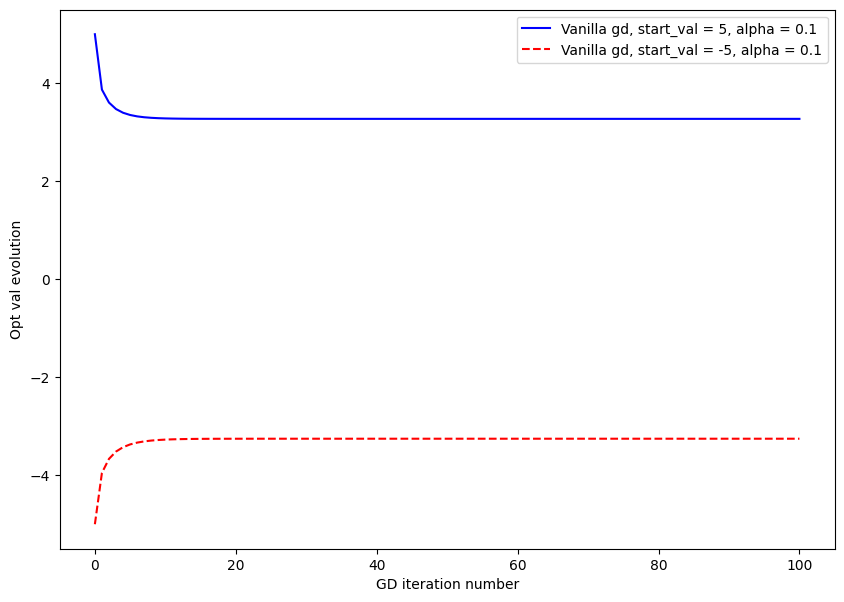

In [8]:
plt.figure(figsize = (10, 7))
plt.plot(range(len(val_list_vanilla_gd1)), val_list_vanilla_gd1, "b", label = "Vanilla gd, start_val = 5, alpha = 0.1")
plt.plot(range(len(val_list_vanilla_gd2)), val_list_vanilla_gd2, "r--", label = "Vanilla gd, start_val = -5, alpha = 0.1")
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Adding momentum to try and escape the local min

The phenomemon described above typically shows the main limitation of the vanilla gradient descent: this algorithm is simple and works fine with convex functions. Unfortunately, in the presence of local non-global minima, the algorithm might end up getting trapped and converging to the wrong value.

In the case of our Shallow Neural Networks, this could lead to suboptimal parameters $ W $ and $ b $, which are not going to minimize the loss functions used for training.

In an attempt to alleviate this phenomenon, we propose to use **momentum**.

Momentum is a method that helps accelerate the training process by updating the weights of the model by reusing values from the past gradients. The idea is that, if a direction in the parameters space consistently leads to good reduction in the loss function, then that direction should be reinforced.

Momentum can be implemented by adding a term to the parameter update, for instance:

$$ x \leftarrow x - \alpha f'(x) + \mu f'_{prev} $$.

As before, $  \alpha $ is a hyperparameter that controls the step size at each iteration. The momentum $ \mu $ is another hyperparameter that controls the influence of the previous gradient update $ f'_{prev}  $.

Using momentum can help the model converge to a good solution faster and with fewer oscillations, especially when training on noisy or complex data. It can also help escape local minima and converge to global minima instead. However, it can also cause the model to overshoot the global minimum and diverge, so it's important to tune the momentum hyperparameter $ \mu $ carefully.

We implement the momentum gradient descent below, in **momentum_gd()**.

In [9]:
def momentum_gd(start_val, alpha = 0.1, mu = 0.1, n_iter = 100):
    val = start_val
    mom = 0
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradient and momentum
        grad = -alpha*obj_fun_deriv(val)
        mom = mu*mom + grad
        # Update value
        val += mom
        list_vals.append(val)
    return val, list_vals

As before, when the sarting point is good, we will again converge to the global minimum.

In [10]:
opt_val_momentum_gd1, val_list_momentum_gd1 = momentum_gd(start_val = 5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by momentum gd: ", opt_val_momentum_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by momentum gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


As before, when the sarting point is bad, we will again converge to the local non-global minimum if the moment is not strong enough.

In [11]:
opt_val_momentum_gd2, val_list_momentum_gd2 = momentum_gd(start_val = -5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by momentum gd: ", opt_val_momentum_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by momentum gd:  -3.254993730859254
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


However, with an appropriate momentum value, we might escape the local minimum and converge to the global minimum instead.

In [12]:
opt_val_momentum_gd3, val_list_momentum_gd3 = momentum_gd(start_val = -5, alpha = 0.1, mu = 0.9, n_iter = 100)
print("Optimal, found by momentum gd: ", opt_val_momentum_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by momentum gd:  3.267681061691328
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


All three scenarios are shown below.

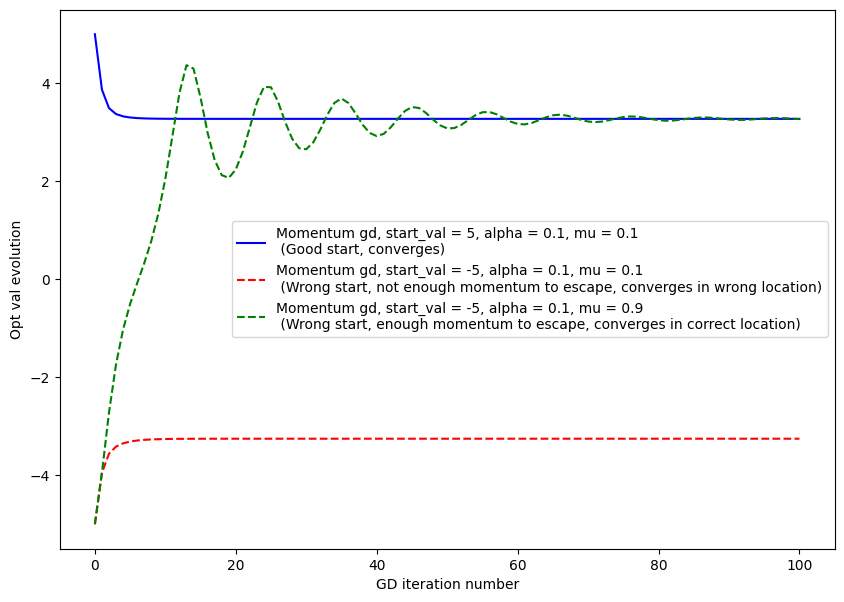

In [13]:
plt.figure(figsize = (10, 7))
label1 = "Momentum gd, start_val = 5, alpha = 0.1, mu = 0.1"
label1 += " \n (Good start, converges)"
plt.plot(range(len(val_list_momentum_gd1)), val_list_momentum_gd1, "b", label = label1)
label2 = "Momentum gd, start_val = -5, alpha = 0.1, mu = 0.1"
label2 += " \n (Wrong start, not enough momentum to escape, converges in wrong location)"
plt.plot(range(len(val_list_momentum_gd2)), val_list_momentum_gd2, "r--", label = label2)
label3 = "Momentum gd, start_val = -5, alpha = 0.1, mu = 0.9"
label3 += " \n (Wrong start, enough momentum to escape, converges in correct location)"
plt.plot(range(len(val_list_momentum_gd3)), val_list_momentum_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### A variation on momentum, the Nesterov Accelerated Gradient (NAG)

Nesterov accelerated gradient descent (NAG) is a variant of stochastic gradient descent that can help accelerate convergence and improve the optimization of deep learning models. It does this by incorporating the concept of momentum, although in a slightly different way than before, which helps the optimization algorithm to continue moving in the same direction even if the gradients change.

In [14]:
def nesterov_gd(start_val, alpha = 0.1, mu = 0.1, n_iter = 100):
    val = start_val
    mom = 0
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradient and Nesterov momentum
        grad = -alpha*obj_fun_deriv(val)
        mom = mu*mom + grad
        # Update value
        val += mu*mom + grad
        list_vals.append(val)
    return val, list_vals

As before, all three scenarios can be investigated.

In [15]:
opt_val_nesterov_gd1, val_list_nesterov_gd1 = nesterov_gd(start_val = 5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by Nesterov gd: ", opt_val_nesterov_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Nesterov gd:  3.2727653395584366
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [16]:
opt_val_nesterov_gd2, val_list_nesterov_gd2 = nesterov_gd(start_val = -5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by Nesterov gd: ", opt_val_nesterov_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Nesterov gd:  -3.254993730859254
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [17]:
opt_val_nesterov_gd3, val_list_nesterov_gd3 = nesterov_gd(start_val = -5, alpha = 0.2, mu = 0.9, n_iter = 100)
print("Optimal, found by Nesterov gd: ", opt_val_nesterov_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Nesterov gd:  3.2727653395584357
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


As before, all three scenarios are shown below.

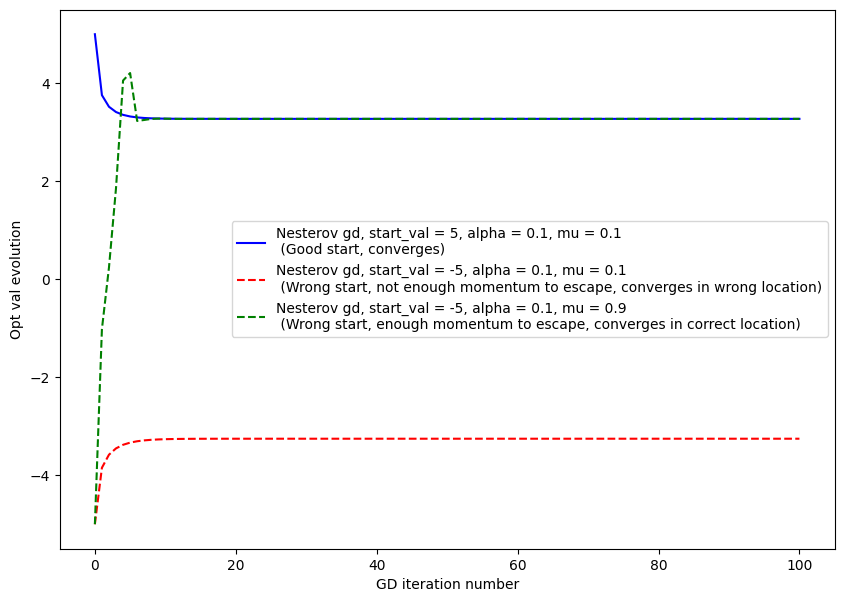

In [18]:
plt.figure(figsize = (10, 7))
label1 = "Nesterov gd, start_val = 5, alpha = 0.1, mu = 0.1"
label1 += " \n (Good start, converges)"
plt.plot(range(len(val_list_nesterov_gd1)), val_list_nesterov_gd1, "b", label = label1)
label2 = "Nesterov gd, start_val = -5, alpha = 0.1, mu = 0.1"
label2 += " \n (Wrong start, not enough momentum to escape, converges in wrong location)"
plt.plot(range(len(val_list_nesterov_gd1)), val_list_nesterov_gd2, "r--", label = label2)
label3 = "Nesterov gd, start_val = -5, alpha = 0.1, mu = 0.9"
label3 += " \n (Wrong start, enough momentum to escape, converges in correct location)"
plt.plot(range(len(val_list_nesterov_gd1)), val_list_nesterov_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Using a simple learning rate decay in Vanilla GD

Another option to control the convergence of the gradient descent algorithm and prevent it from overshooting the global minimum consists of using a **learning rate decay**.

Learning rate decay is a technique used to gradually reduce the learning rate of a neural network during training. The idea is to start with a relatively high learning rate, which can help the model to converge quickly in the early stages of training, and then gradually reduce the learning rate as training progresses.

This can help the model to continue learning and improving even as it gets closer to a good solution, and can also help to prevent overfitting by preventing the model from making overly large updates to its parameters.

There are several ways to implement learning rate decay, such as reducing the learning rate by a fixed amount at regular intervals, or reducing it according to a pre-defined schedule.

We implement one possible option below, which updates the learning rate at the beginning of each iteration with the following formula:

$$ \alpha \leftarrow 0.99\alpha $$ 

In [19]:
def vanilla_gd_lrdecay(start_val, alpha = 0.1, alpha_decay_fac = 0.99, n_iter = 100):
    val = start_val
    list_vals = [val]
    for iter_num in range(n_iter):
        # Decay on LR
        alpha *= alpha_decay_fac
        # Update value
        val += -alpha*obj_fun_deriv(val)
        list_vals.append(val)
    return val, list_vals

Using different values for decay (with a special case of alpha_decay_fac $ = 1 $), allows us to see how we might overshoot the minimum or not. Decaying too fast might even push the algorithm to converge to a location that is not even a minimum.

In [20]:
opt_val_lrdecay_gd1, val_list_lrdecay_gd1 = vanilla_gd_lrdecay(start_val = 5, \
                                                              alpha = 0.2, \
                                                              alpha_decay_fac = 1, \
                                                              n_iter = 100)
print("Optimal, found by Vanilla LR decay gd: ", opt_val_lrdecay_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [21]:
opt_val_lrdecay_gd2, val_list_lrdecay_gd2 = vanilla_gd_lrdecay(start_val = 5, \
                                                               alpha = 0.2, \
                                                               alpha_decay_fac = 0.75, \
                                                               n_iter = 100)
print("Optimal, found by Vanilla LR decay gd: ", opt_val_lrdecay_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR decay gd:  3.2779747340306966
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [22]:
opt_val_lrdecay_gd3, val_list_lrdecay_gd3 = vanilla_gd_lrdecay(start_val = 5, \
                                                               alpha = 0.2, \
                                                               alpha_decay_fac = 0.5, \
                                                               n_iter = 100)
print("Optimal, found by Vanilla LR decay gd: ", opt_val_lrdecay_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR decay gd:  3.6473725891985467
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


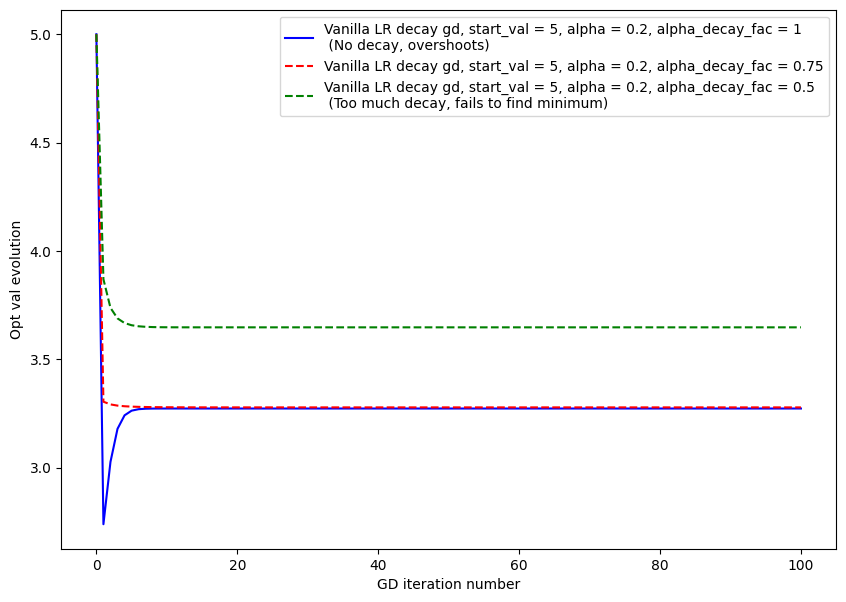

In [23]:
plt.figure(figsize = (10, 7))
label1 = "Vanilla LR decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 1"
label1 += " \n (No decay, overshoots)"
plt.plot(range(len(val_list_lrdecay_gd1)), val_list_lrdecay_gd1, "b", label = label1)
label2 = "Vanilla LR decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.75"
label1 += " \n (Optimal decay?)"
plt.plot(range(len(val_list_lrdecay_gd2)), val_list_lrdecay_gd2, "r--", label = label2)
label3 = "Vanilla LR decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.5"
label3 += " \n (Too much decay, fails to find minimum)"
plt.plot(range(len(val_list_lrdecay_gd3)), val_list_lrdecay_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Dome additional examples of decay functions

Many other functions can be used to produce a decay on the learning rate. Below are a few notable examples.

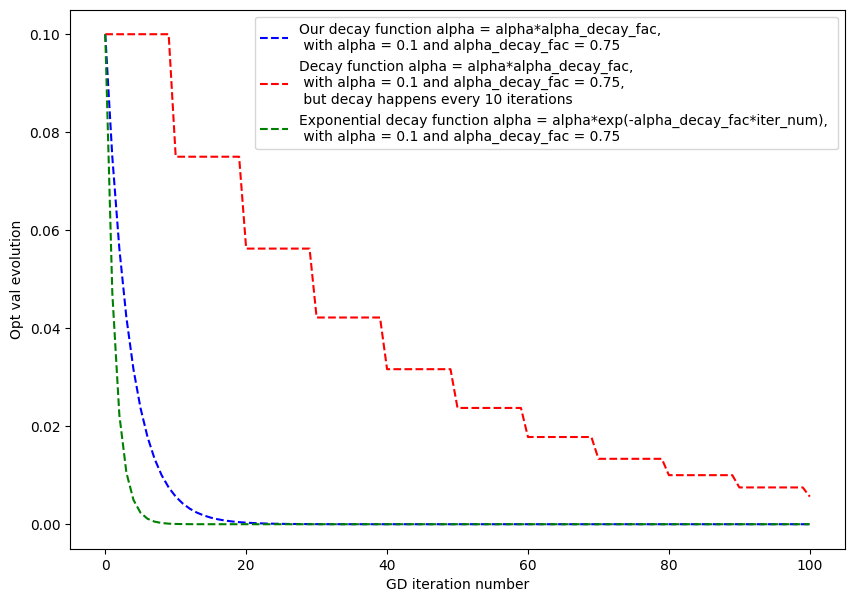

In [24]:
plt.figure(figsize = (10, 7))
label1 = "Our decay function alpha = alpha*alpha_decay_fac,"
label1 += " \n with alpha = 0.1 and alpha_decay_fac = 0.75"
plt.plot(range(101), [0.1*(0.75)**i for i in range(101)], "b--", label = label1)
label2 = "Decay function alpha = alpha*alpha_decay_fac,"
label2 += " \n with alpha = 0.1 and alpha_decay_fac = 0.75,"
label2 += " \n but decay happens every 10 iterations"
plt.plot(range(101), [0.1*(0.75)**(i//10) for i in range(101)], "r--", label = label2)
label3 = "Exponential decay function alpha = alpha*exp(-alpha_decay_fac*iter_num),"
label3 += " \n with alpha = 0.1 and alpha_decay_fac = 0.75"
plt.plot(range(101), [0.1*np.exp(-0.75*i) for i in range(101)], "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Using a gradient-based learning rate decay in Vanilla GD

Other options for decay suggest to use the value of the gradients to adjust the learning rate accordingly.

Gradients are often used in learning rate decay formulas because they provide a measure of how much the parameters are changing with each update. The magnitude of the gradients can give us an indication of how much "learning" is done at each step, and can be used to adjust the learning rate accordingly.

For example, if the gradients are large, it may indicate that we are is still making significant progress and are able to adjust parameters effectively at a high learning rate. In this case, we may want to keep the learning rate high to allow the algorithm to continue adjusting the parameters quickly.

On the other hand, if the gradients are small, it may indicate that we are close to converging and are making only small updates to the parameters. In this case, we may want to reduce the learning rate to continue improving, but at a slower pace to prevent overshooting the minimum.

By incorporating gradients into the learning rate decay formula, we can dynamically adjust the learning rate based on the current learning progress. This, in turn, helps to continue improving effectively as we get closer to a good solution.

**Do note however, that this is a risky strategy, and it is often preferable for learning rate decay schemes to do the opposite, that is making the learning rate inversely proportional to the mean gradient value (or its mean squared value).**

By doing so, if the gradients are small (i.e. the model is making small updates to its weights), the learning rate will be high, and if the gradients are large (i.e. the model is making large updates to its weights), the learning rate will be low. This can also help to prevent the model from making overly large updates, which can help to improve generalization and prevent overfitting.

This is typically another example of the **"No free lunch theorem"**.

We implement a possible learning rate decay mechanism, using the gradients and the learning rate decay factor $ \alpha_{df}$, below.

$$ \alpha = \frac{1}{1 + \alpha_{df} \sqrt{|f'(x)|}} $$

In [25]:
def vanilla_gd_gradlrdecay(start_val, alpha = 0.1, alpha_decay_fac = 0.99, n_iter = 100):
    val = start_val
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradients
        grad = obj_fun_deriv(val)
        # Gradient-based decay on LR
        alpha *= 1/(1 + alpha_decay_fac*np.sqrt(np.abs(grad)))
        # Update value
        val += -alpha*grad
        list_vals.append(val)
    return val, list_vals

In [26]:
opt_val_gradlrdecay_gd1, val_list_gradlrdecay_gd1 = vanilla_gd_gradlrdecay(start_val = 5, \
                                                                           alpha = 0.2, \
                                                                           alpha_decay_fac = 0.1, \
                                                                           n_iter = 100)
print("Optimal, found by Vanilla LR grad-decay gd: ", opt_val_gradlrdecay_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR grad-decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [27]:
opt_val_gradlrdecay_gd2, val_list_gradlrdecay_gd2 = vanilla_gd_gradlrdecay(start_val = 5, \
                                                                           alpha = 0.2, \
                                                                           alpha_decay_fac = 0, \
                                                                           n_iter = 100)
print("Optimal, found by Vanilla LR grad-decay gd: ", opt_val_gradlrdecay_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR grad-decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [28]:
opt_val_gradlrdecay_gd3, val_list_gradlrdecay_gd3 = vanilla_gd_gradlrdecay(start_val = 5, \
                                                                           alpha = 0.2, \
                                                                           alpha_decay_fac = 0.05, \
                                                                           n_iter = 100)
print("Optimal, found by Vanilla LR grad-decay gd: ", opt_val_gradlrdecay_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR grad-decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


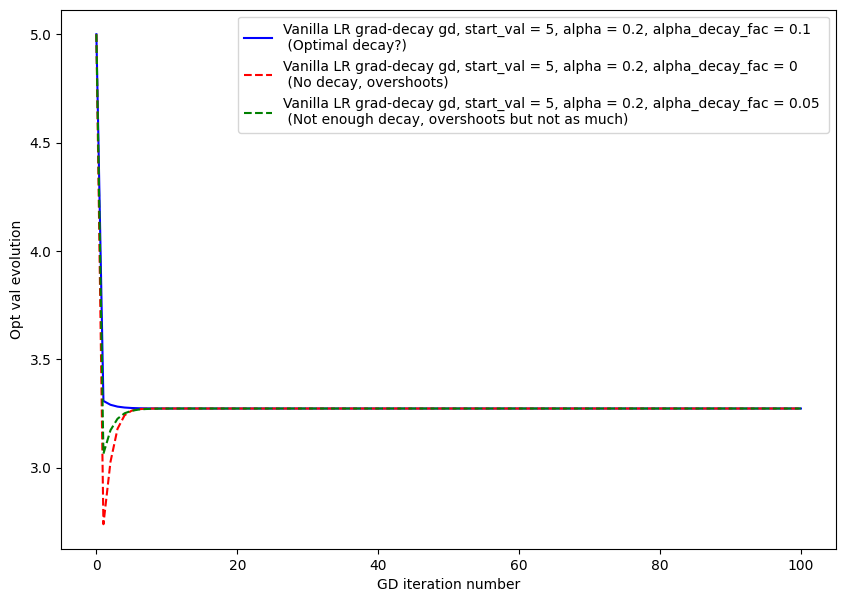

In [29]:
plt.figure(figsize = (10, 7))
label1 = "Vanilla LR grad-decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.1"
label1 += " \n (Optimal decay?)"
plt.plot(range(len(val_list_gradlrdecay_gd1)), val_list_gradlrdecay_gd1, "b", label = label1)
label2 = "Vanilla LR grad-decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0"
label2 += " \n (No decay, overshoots)"
plt.plot(range(len(val_list_gradlrdecay_gd2)), val_list_gradlrdecay_gd2, "r--", label = label2)
label3 = "Vanilla LR grad-decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.05"
label3 += " \n (Not enough decay, overshoots but not as much)"
plt.plot(range(len(val_list_gradlrdecay_gd3)), val_list_gradlrdecay_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Mock dataset, with nonlinearity

As in the previous notebook, we will reuse our nonlinear binary classification mock dataset and generate 1000 samples.

In [30]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 1000
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [31]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(val1_list.shape)
print(val2_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(1000,)
(1000,)
(1000, 2)
(1000, 1)
[[-0.77 -0.6 ]
 [ 0.95  0.28]
 [ 0.46 -0.91]
 [-0.3   0.23]
 [ 0.42 -0.61]
 [ 0.6   0.97]
 [ 0.29  0.37]
 [-0.17  0.4 ]
 [ 0.41  0.29]
 [-0.51  0.02]]
[[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]]


As expected and observed in the plots below, the dataset now longer exhibits linearity.

In fact, the function is no longer polynomial either due to the presence of a sine function.

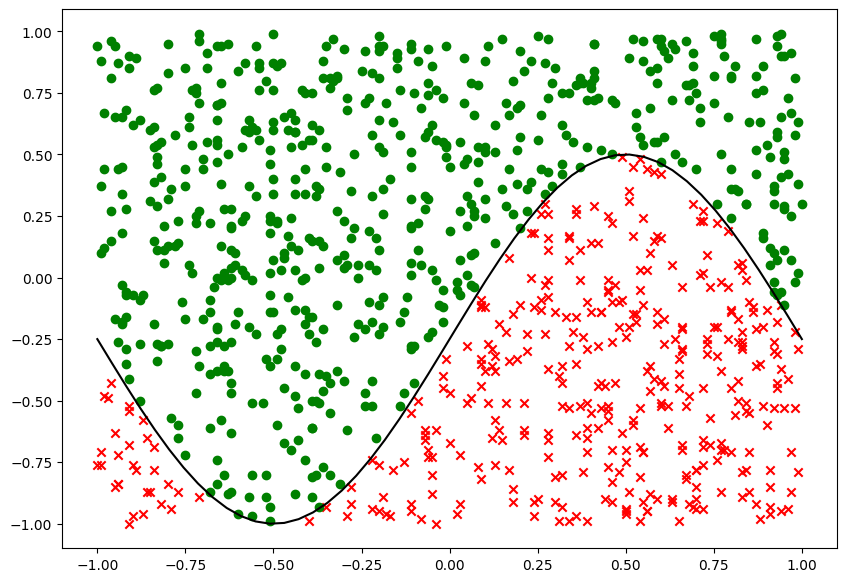

In [32]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### Shallow Neural Net with Sigmoid Activations, Vanilla Gradient Descent in Backprop

As in the previous notebook, we will reuse our ShallowNeuralNet class, using fully connected layers and sigmoid activation functions. It implements a Vanilla Gradient Descent algorithm, which does the job just fine. As we will implement more sophisticated version of the gradient descent algorithm, let us rename this class as **ShallowNeuralNet_VanillaGD** for now.

In [33]:
class ShallowNeuralNet_VanillaGD():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        gradient_output = dL_dA2*A2*(1 - A2)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Gradient descent update rules
        self.W2 -= (1/m)*alpha*np.dot(A1.T, gradient_output)
        self.W1 -= (1/m)*alpha*np.dot(inputs.T, gradient_hidden)
        self.b2 -= (1/m)*alpha*np.sum(gradient_output, axis = 0, keepdims = True)
        self.b1 -= (1/m)*alpha*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Update loss
        self.CE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

It trains just fine on our dataset.

In [34]:
# Define and train neural network structure (Vanilla GD)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_vanilla = ShallowNeuralNet_VanillaGD(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_vanilla.train(inputs, outputs, N_max = 10000, alpha = 1, delta = 1e-10, display = True)
print(shallow_neural_net_vanilla.loss)

Iteration 1 - Loss = 0.6596594543503731
Iteration 501 - Loss = 0.26562970423019194
Iteration 1001 - Loss = 0.20264058765935106
Iteration 1501 - Loss = 0.15502118227704528
Iteration 2001 - Loss = 0.12562659972147602
Iteration 2501 - Loss = 0.10509763691597696
Iteration 3001 - Loss = 0.09037444261742042
Iteration 3501 - Loss = 0.07868783669927487
Iteration 4001 - Loss = 0.06890517471602234
Iteration 4501 - Loss = 0.06104499911880908
Iteration 5001 - Loss = 0.0549213998708969
Iteration 5501 - Loss = 0.05015561086769172
Iteration 6001 - Loss = 0.04639640210705564
Iteration 6501 - Loss = 0.04337766407581476
Iteration 7001 - Loss = 0.040908991515814376
Iteration 7501 - Loss = 0.03885535088693221
Iteration 8001 - Loss = 0.037120169060300155
Iteration 8501 - Loss = 0.03563337765226061
Iteration 9001 - Loss = 0.03434331633523067
Iteration 9501 - Loss = 0.03321128269586246
Stopping - Maximal number of iterations reached.
0.03220973033615074


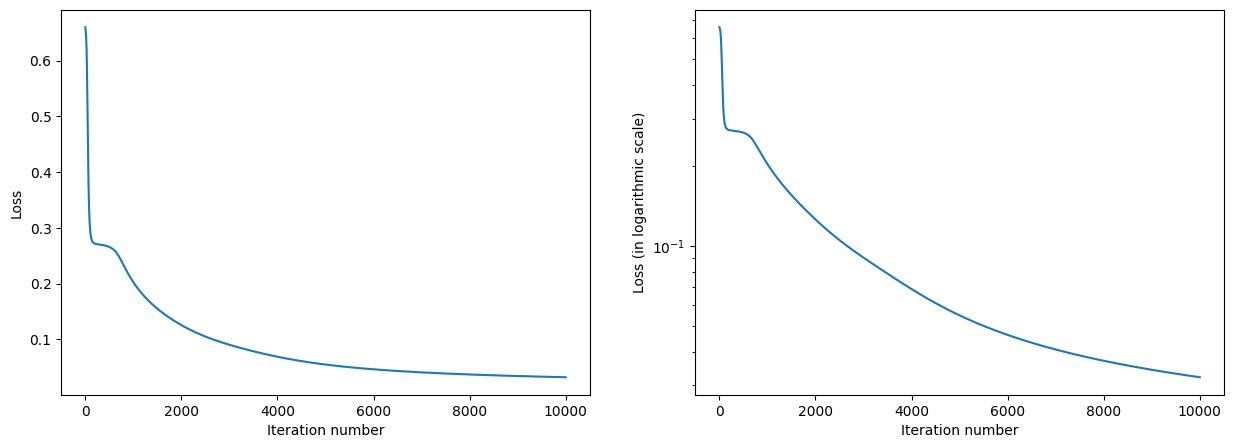

In [35]:
shallow_neural_net_vanilla.show_losses_over_training()

### Shallow Neural Net with Sigmoid Activations, AdaGrad in Backprop

The first variation of the gradient descent algorithm we will implement is AdaGrad

This variation of gradient descent adapts the learning rate for each parameter separately, based on the historical gradient information for that parameter. In that sense, it is an implementation using a learning rate scheduler based on the value of gradients. AdaGrad scales down the learning rate for parameters that have received a large number of updates, which can help prevent overfitting and improve the generalization ability of the model.

The gradient descent rule relies on four parameters $ G_{W2} $, $ G_{W1} $, $ G_{b2} $ and $ G_{b1} $. Their values are defined as the squared values of the gradients with respect to each parameter. For instance, we have:

$$ G_{W2} = \left( \frac{\partial L}{\partial W2} \right)^2 $$

This value is then used to adjust the larning rate $ \alpha_{W2} $ for the W2 update rule:

$$ \alpha_{W2} = \frac{\alpha}{\sqrt{G_{W2} + \epsilon}} $$

Here, the value of $ \epsilon $ is set to $ 1e^{-6} $ and is simply used to prevent divisions by zero. The update rule for $ W2 $ is then defined, as before, as:

$$ W2 \leftarrow W2 - \alpha_{W2} \frac{\partial L}{\partial W2} $$

This is implemented in the **backward()** method of the **ShallowNeuralNet_AdaGrad** class below. More specifically, have a look at the lines:

```
# Compute gradients
grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)

# Momentum and gradient decay/normalization for each parameter
G_W2, G_W1, G_b2, G_b1 = G_list
G_W2 += grad_W2**2
G_W1 += grad_W1**2
G_b2 += grad_b2**2
G_b1 += grad_b1**2
G_list = [G_W2, G_W1, G_b2, G_b1]

# Gradient descent update rules
eps = 1e-6
self.W2 += alpha*grad_W2/(np.sqrt(G_W2 + eps))
self.W1 += alpha*grad_W1/(np.sqrt(G_W1 + eps))
self.b2 += alpha*grad_b2/(np.sqrt(G_b2 + eps))
self.b1 += alpha*grad_b1/(np.sqrt(G_b1 + eps))
```

In [36]:
class ShallowNeuralNet_AdaGrad():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        gradient_output = dL_dA2*A2*(1 - A2)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        G_W2, G_W1, G_b2, G_b1 = G_list
        G_W2 += grad_W2**2
        G_W1 += grad_W1**2
        G_b2 += grad_b2**2
        G_b1 += grad_b1**2
        G_list = [G_W2, G_W1, G_b2, G_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*grad_W2/(np.sqrt(G_W2 + eps))
        self.W1 += alpha*grad_W1/(np.sqrt(G_W1 + eps))
        self.b2 += alpha*grad_b2/(np.sqrt(G_b2 + eps))
        self.b1 += alpha*grad_b1/(np.sqrt(G_b1 + eps))
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

Let us try this AdaGrad model and verify that it is able to train just fine.

In [56]:
# Define and train neural network structure (Adagrad)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_adagrad = ShallowNeuralNet_AdaGrad(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_adagrad.train(inputs, outputs, N_max = 10000, alpha = 1e-2, delta = 1e-10, display = True)
print(shallow_neural_net_adagrad.loss)

Iteration 1 - Loss = 0.6784199334556532
Iteration 501 - Loss = 0.5331547761742477
Iteration 1001 - Loss = 0.43902499733078154
Iteration 1501 - Loss = 0.38545252936125146
Iteration 2001 - Loss = 0.35267303942709305
Iteration 2501 - Loss = 0.33113552990271694
Iteration 3001 - Loss = 0.3162342379704586
Iteration 3501 - Loss = 0.3055415781276059
Iteration 4001 - Loss = 0.2976637903144858
Iteration 4501 - Loss = 0.29174317914155723
Iteration 5001 - Loss = 0.2872232331348417
Iteration 5501 - Loss = 0.2837282122951798
Iteration 6001 - Loss = 0.2809966034383635
Iteration 6501 - Loss = 0.27884196814279233
Iteration 7001 - Loss = 0.2771287396665793
Iteration 7501 - Loss = 0.2757566757881142
Iteration 8001 - Loss = 0.2746505648833983
Iteration 8501 - Loss = 0.27375323916382477
Iteration 9001 - Loss = 0.2730207313219953
Iteration 9501 - Loss = 0.27241885407185307
Stopping - Maximal number of iterations reached.
0.2719216518438061


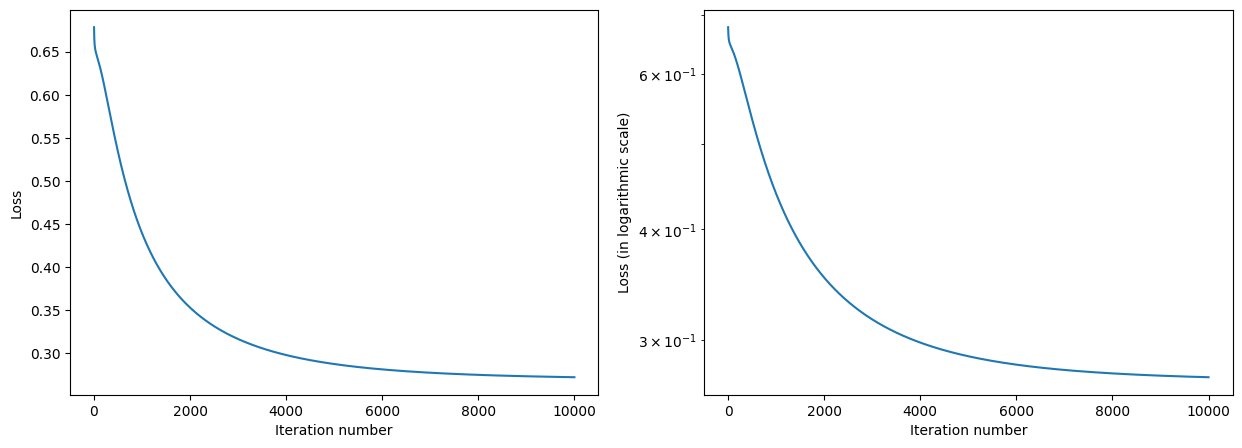

In [57]:
shallow_neural_net_adagrad.show_losses_over_training()

### Shallow Neural Net with Sigmoid Activations, RMSProp in Backprop

As before with AdaGrad, we propose to investigate another gradient descent variation, called RMSProp (Root Mean Squared Propagation). We will implement it in the **ShallowNeuralNet_RMSProp** class below.

This RMSProp variation of the gradient descent is similar to AdaGrad, but it uses a running average of the squared gradients to scale the learning rate for each parameter, rather than using the sum of the squared gradients as in AdaGrad. RMSProp can be less sensitive to the learning rate than AdaGrad, and it is often used in conjunction with other techniques such as momentum. We will typically keep this idea in mind for later when designing the Adam optimizer.

For now, let us discuss the mathematical equations behind RMSProp. As before, in AdaGrad, RMSProp relies on four parameters $ G_{W2} $, $ G_{W1} $, $ G_{b2} $ and $ G_{b1} $. Their values are no longer defined as the squared values of the gradients with respect to each parameter, but instead use a mixed formula reusing the previous values of these parameters, mixed with the current squared values of the gradients. This reuses the logic of the momentum formula we discussed earlier and it is implemented here as:

$$ G_{W2} = (1 - \rho) \left( \frac{\partial L}{\partial W2} \right)^2  + \rho G_{W2}$$

Here, $ \rho $ is an hyperparameter, whose value is set between 0 and 1, often set to 0.1. This value is then used to adjust the larning rate $ \alpha_{W2} $ for the W2 update rule, just like before:

$$ \alpha_{W2} = \frac{\alpha}{\sqrt{G_{W2} + \epsilon}} $$

As before, the value of $ \epsilon $ is set to $ 1e^{-6} $ and is simply used to prevent divisions by zero. The update rule for $ W2 $ is then defined, as before, as:

$$ W2 \leftarrow W2 - \alpha_{W2} \frac{\partial L}{\partial W2} $$

This is typically implemented in the lines below.

```
# Momentum and gradient decay/normalization for each parameter
G_W2, G_W1, G_b2, G_b1 = G_list
G_W2 = rho*G_W2 + (1 - rho)*grad_W2**2
G_W1 = rho*G_W1 + (1 - rho)*grad_W1**2
G_b2 = rho*G_b2 + (1 - rho)*grad_b2**2
G_b1 = rho*G_b1 + (1 - rho)*grad_b1**2
G_list = [G_W2, G_W1, G_b2, G_b1]

# Gradient descent update rules
eps = 1e-6
self.W2 += alpha*grad_W2/(np.sqrt(G_W2 + eps))
self.W1 += alpha*grad_W1/(np.sqrt(G_W1 + eps))
self.b2 += alpha*grad_b2/(np.sqrt(G_b2 + eps))
self.b1 += alpha*grad_b1/(np.sqrt(G_b1 + eps))
```

In [58]:
class ShallowNeuralNet_RMSProp():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, alpha = 1e-5, rho = 0.1):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        gradient_output = dL_dA2*A2*(1 - A2)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        G_W2, G_W1, G_b2, G_b1 = G_list
        G_W2 = rho*G_W2 + (1 - rho)*grad_W2**2
        G_W1 = rho*G_W1 + (1 - rho)*grad_W1**2
        G_b2 = rho*G_b2 + (1 - rho)*grad_b2**2
        G_b1 = rho*G_b1 + (1 - rho)*grad_b1**2
        G_list = [G_W2, G_W1, G_b2, G_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*grad_W2/(np.sqrt(G_W2 + eps))
        self.W1 += alpha*grad_W1/(np.sqrt(G_W1 + eps))
        self.b2 += alpha*grad_b2/(np.sqrt(G_b2 + eps))
        self.b1 += alpha*grad_b1/(np.sqrt(G_b1 + eps))
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, rho = 0.1, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, alpha, rho)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

Let us check that this model is ble to train. RMSProp tends to "oscillate" a bit more around the minima, due to the momentum.

In [62]:
# Define and train neural network structure (RMSProp)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_rmsprop = ShallowNeuralNet_RMSProp(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_rmsprop.train(inputs, outputs, N_max = 3000, alpha = 1e-2, rho = 0.9, delta = 1e-10, display = True)
print(shallow_neural_net_rmsprop.loss)

Iteration 1 - Loss = 0.6668122087361696
Iteration 151 - Loss = 0.2710024035638195
Iteration 301 - Loss = 0.24351490875871032
Iteration 451 - Loss = 0.18805813548990175
Iteration 601 - Loss = 0.14841861731507897
Iteration 751 - Loss = 0.11896167188785028
Iteration 901 - Loss = 0.097577889501624
Iteration 1051 - Loss = 0.08000702507372376
Iteration 1201 - Loss = 0.0651202977816896
Iteration 1351 - Loss = 0.05323168382957508
Iteration 1501 - Loss = 0.044450134546600524
Iteration 1651 - Loss = 0.038155957169659076
Iteration 1801 - Loss = 0.03353151931662028
Iteration 1951 - Loss = 0.029985759047684624
Iteration 2101 - Loss = 0.02719169788967961
Iteration 2251 - Loss = 0.024952596720246037
Iteration 2401 - Loss = 0.023115251808675245
Iteration 2551 - Loss = 0.02157319330714698
Iteration 2701 - Loss = 0.020254924594782217
Iteration 2851 - Loss = 0.01911007422145339
Stopping - Maximal number of iterations reached.
0.018108111244684054


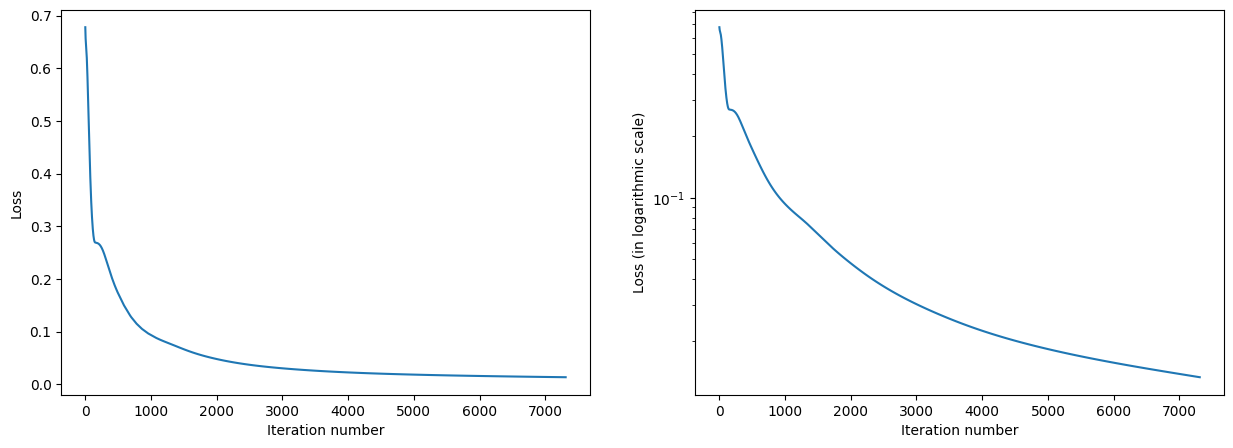

In [60]:
shallow_neural_net_rmsprop.show_losses_over_training()

### Shallow Neural Net with Sigmoid Activations, Adam in Backprop

Finally, let us investigate the Adam backpropagation, as this is one of the most popular optimizers used in Deep Learning. 

Adam is a popular variation of gradient descent that combines the ideas of momentum and RMSProp. Adam uses an exponentially decaying average of the past gradients to scale the learning rate for each parameter, and it also uses an exponentially decaying average of the past squared gradients to scale the learning rate.

Adam is widely used in Deep Learning applications because it can often achieve good performance with relatively little hyperparameter tuning.

As before, in AdaGrad and RMSProp, Adam relies on additional parameters: this time, it will be eight of them, denoted $ V_{W2} $, $ V_{W1} $, $ V_{b2} $,  $ V_{b1} $, $ S_{W2} $, $ S_{W1} $, $ S_{b2} $ and $ S_{b1} $.

The $ V $ values are defined as in RMSProp, and use a mixed formula reusing the previous values of these parameters, mixed with the current values of the gradients. This reuses the logic of the momentum formula we discussed earlier and it is implemented here as:

$$ V_{W2} = (1 - \beta_1) \left( \frac{\partial L}{\partial W2} \right)  + \beta_1 V_{W2} $$

Here, $ \beta_1 $ is an hyperparameter, whose value is set between 0 and 1, often set to 0.9.
An optional step consists of normalizing $ V_{W2} $ after that, by dividing its current value by (1 - \beta_1^t) $, where $ t $ is the iteration number. In a sense, this creates a learning rate decay, progressively decreasing the value of $ V_{W2}  $ over time.

$$ V_{W2} \leftarrow \frac{V_{W2}}{1 - \beta_1^t} $$

The $ S $ values are defined as in RMSProp, and use a mixed formula reusing the previous values of these parameters, mixed with the current squared values of the gradients. This reuses the logic of the momentum formula we discussed earlier and it is implemented here as:

$$ S_{W2} = (1 - \beta_2) \left( \frac{\partial L}{\partial W2} \right)^2  + \beta_2 S_{W2} $$

Here, $ \beta_2 $ is an hyperparameter, whose value is set between 0 and 1, often set to 0.999.
An optional step consists of normalizing $ S_{W2} $ after that, by dividing its current value by (1 - \beta_2^t) $, where $ t $ is the iteration number. In a sense, this creates a learning rate decay, progressively decreasing the value of $ S_{W2}  $ over time.

$$ S_{W2} \leftarrow \frac{S_{W2}}{1 - \beta_2^t} $$

This value is then used to calculate the change $ C_{W2} $ below, used for the W2 update rule:

$$ C_{W2} = \frac{\alpha V_{W2}}{\sqrt{S_{W2}} + \epsilon} $$

As before, the value of $ \epsilon $ is set to $ 1e^{-6} $ and is simply used to prevent divisions by zero. Do note that $ \epsilon $ is no longer in the square root now. The update rule for $ W2 $ is then defined, as before, as:

$$ W2 \leftarrow W2 - C_{W2} $$

This is typically implemented in the lines below.

```
# Momentum and gradient decay/normalization for each parameter
V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
V_W2_norm = V_W2/(1 - beta1**iteration_number)
V_W1_norm = V_W1/(1 - beta1**iteration_number)
V_b2_norm = V_b2/(1 - beta1**iteration_number)
V_b1_norm = V_b1/(1 - beta1**iteration_number)
S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
S_W2_norm = S_W2/(1 - beta2**iteration_number)
S_W1_norm = S_W1/(1 - beta2**iteration_number)
S_b2_norm = S_b2/(1 - beta2**iteration_number)
S_b1_norm = S_b1/(1 - beta2**iteration_number)
G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]

# Gradient descent update rules
eps = 1e-6
self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
```

In [63]:
class ShallowNeuralNet_Adam():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        A2 = self.sigmoid(Z2_b)
    
        # Compute error term
        dL_dA2 = -outputs/A2 + (1 - outputs)/(1 - A2)
        gradient_output = dL_dA2*A2*(1 - A2)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, iteration_number, alpha, beta1, beta2)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

Let us check that the model trains.

In [67]:
# Define and train neural network structure (Adam)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_adam = ShallowNeuralNet_Adam(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_adam.train(inputs, outputs, N_max = 5000, alpha = 1e-2, beta1 = 0.9, \
                              beta2 = 0.999, delta = 1e-10, display = True)
print(shallow_neural_net_adam.loss)

Iteration 1 - Loss = 0.6783780172579938
Iteration 251 - Loss = 0.2699394313270917
Iteration 501 - Loss = 0.22209633236468027
Iteration 751 - Loss = 0.16030492277754219
Iteration 1001 - Loss = 0.1116588708446451
Iteration 1251 - Loss = 0.07370650132911513
Iteration 1501 - Loss = 0.0533650004990482
Iteration 1751 - Loss = 0.042303709364587924
Iteration 2001 - Loss = 0.03558784580954881
Iteration 2251 - Loss = 0.031069161960263356
Iteration 2501 - Loss = 0.027686824723523885
Iteration 2751 - Loss = 0.024943600401078528
Iteration 3001 - Loss = 0.022636080032493847
Iteration 3251 - Loss = 0.02063352871190029
Iteration 3501 - Loss = 0.018799814177200468
Iteration 3751 - Loss = 0.01703409568286411
Iteration 4001 - Loss = 0.01536933037521938
Iteration 4251 - Loss = 0.013885112186082429
Iteration 4501 - Loss = 0.012579217107025548
Iteration 4751 - Loss = 0.011417960760336254
Stopping - Maximal number of iterations reached.
0.010380390964505538


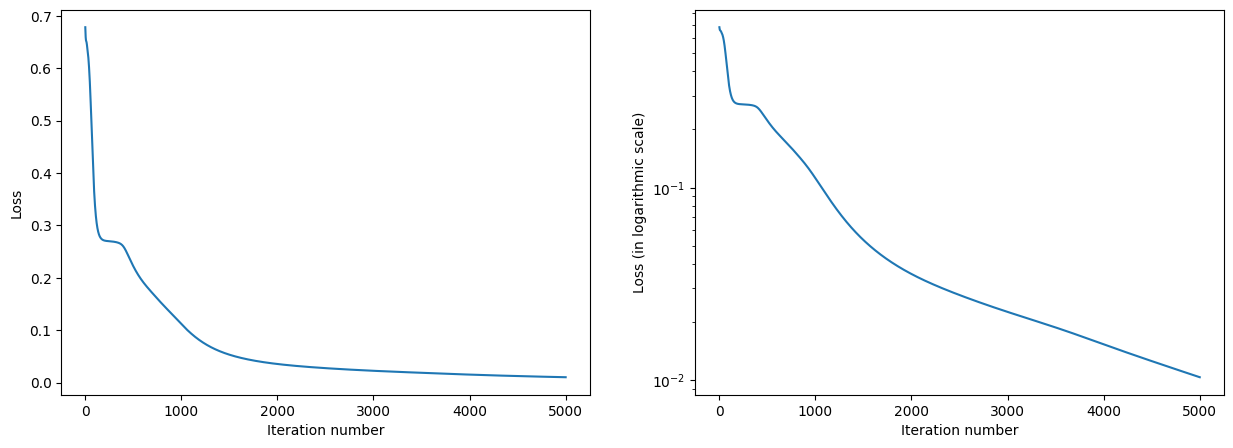

In [68]:
shallow_neural_net_adam.show_losses_over_training()

### Final visualizations and discussion

One might wonder, which of the four designs (Vanilla GD, AdaGrad, RMSProp, Adam) is the best optimizer to use. While it is commonly accepted that Adam is a safe bet most of the time, this is, again, another instance of the **No free lunch theorem**. You would be well advised to try different optimizers, along with different values for their hyperparameters.

For now, the training curves below do confirm that Adam indeed seems to converge faster to lower loss values.

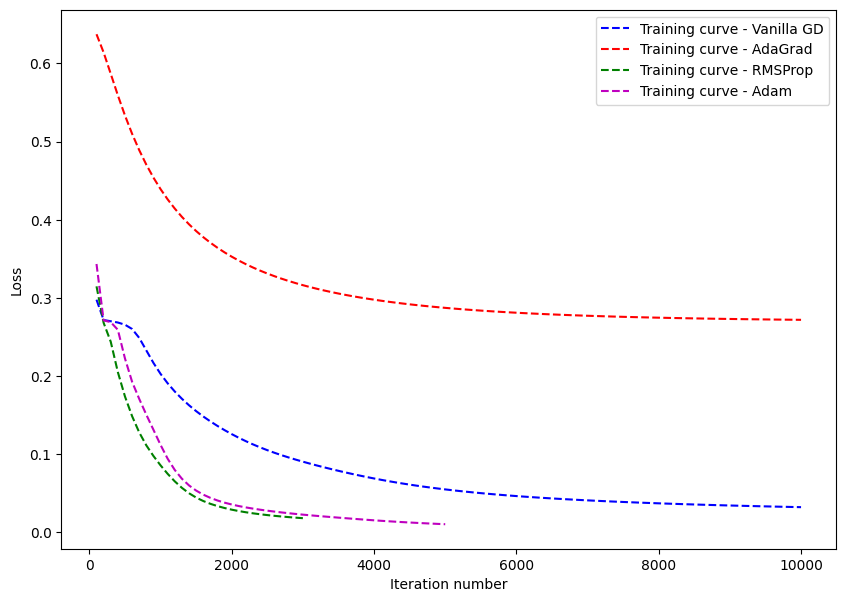

In [70]:
# Compare training curves
fig = plt.figure(figsize = (10, 7))
plt.plot(list(range(0, len(shallow_neural_net_vanilla.losses_list), 100)), \
         shallow_neural_net_vanilla.losses_list[::100], "b--", label = "Training curve - Vanilla GD")
plt.plot(list(range(0, len(shallow_neural_net_adagrad.losses_list), 100)), \
         shallow_neural_net_adagrad.losses_list[::100], "r--", label = "Training curve - AdaGrad")
plt.plot(list(range(0, len(shallow_neural_net_rmsprop.losses_list), 100)), \
         shallow_neural_net_rmsprop.losses_list[::100], "g--", label = "Training curve - RMSProp")
plt.plot(list(range(0, len(shallow_neural_net_adam.losses_list), 100)), \
         shallow_neural_net_adam.losses_list[::100], "m--", label = "Training curve - Adam")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.legend(loc = "best")
plt.show()

Another very common thing to do is to try and display the boundary defined by each of the trained model and check whether the models overfit/underfit the training data. TO do so, we first need a helper function, **find_v2()**,  used to caclulate the boundary, using a simple dichotomic search.

In [71]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

We can then plot the boundary defined by our Vanilla GD model, and observe that it currently underfits the data.

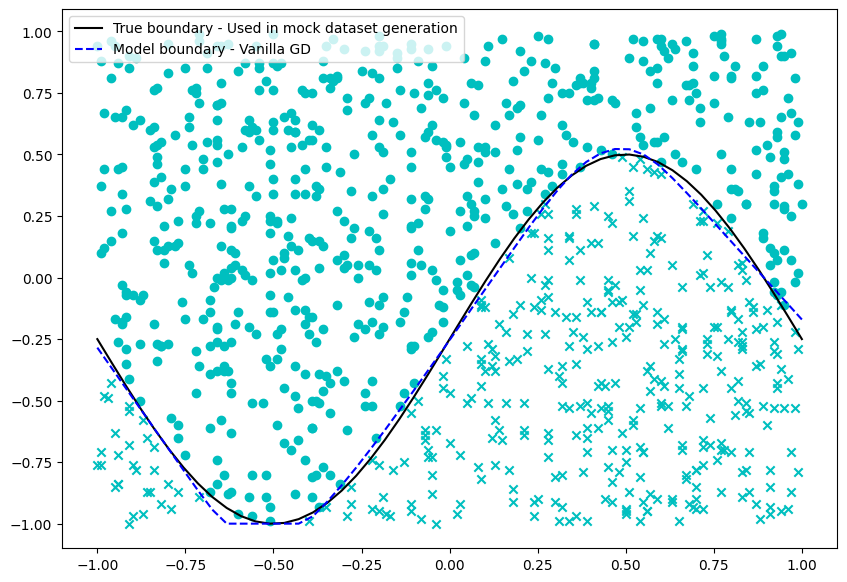

In [72]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_vanilla = [find_v2(v1, shallow_neural_net_vanilla, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_vanilla, "b--", label = "Model boundary - Vanilla GD")

# Show
plt.legend(loc = "best")
plt.show()

The other three optimizers, on the other hand, converged much faster and are able to correctly fit the data. SOme of them might even slightly overfit, in fact.

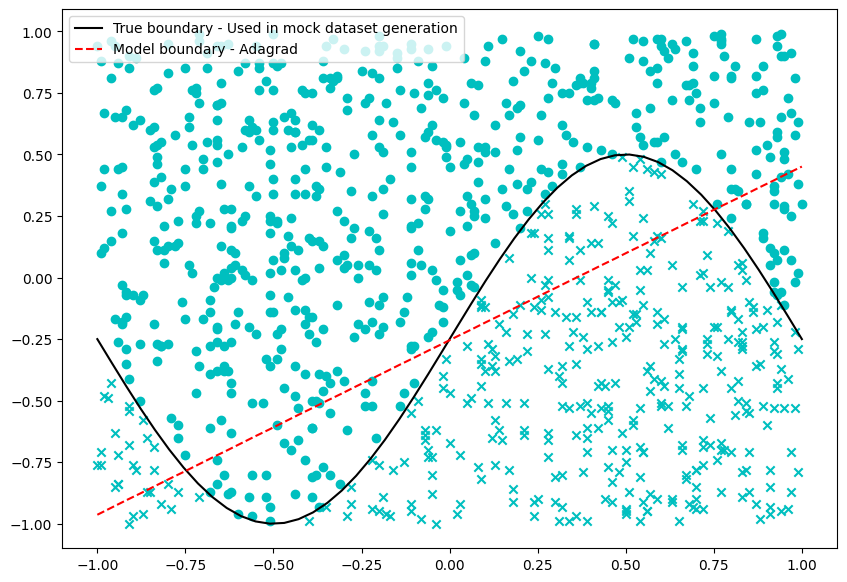

In [73]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adagrad = [find_v2(v1, shallow_neural_net_adagrad, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adagrad, "r--", label = "Model boundary - Adagrad")

# Show
plt.legend(loc = "best")
plt.show()

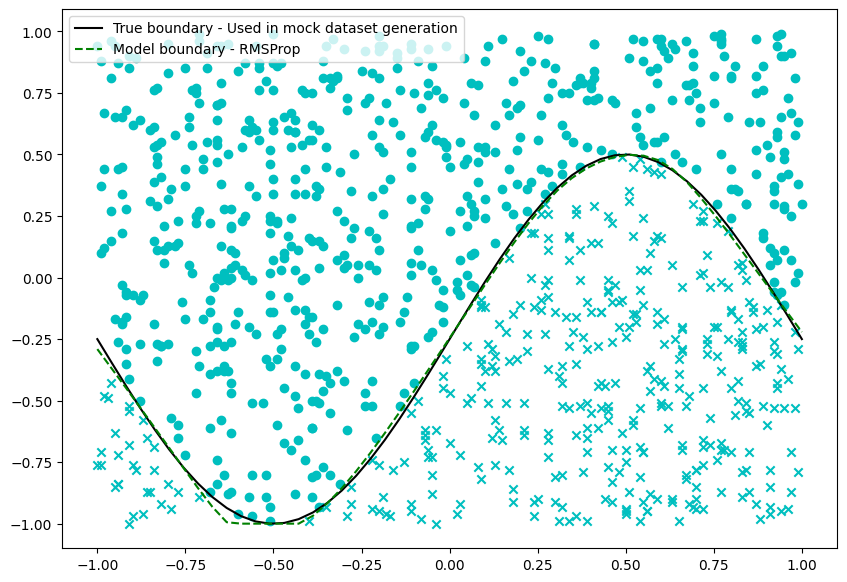

In [74]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, RMSProp GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_rmsprop = [find_v2(v1, shallow_neural_net_rmsprop, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_rmsprop, "g--", label = "Model boundary - RMSProp")

# Show
plt.legend(loc = "best")
plt.show()

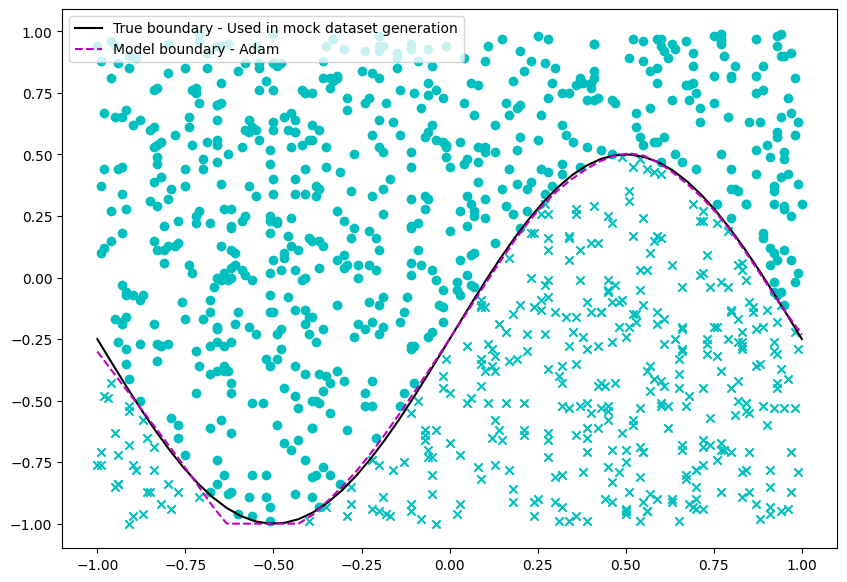

In [75]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adam = [find_v2(v1, shallow_neural_net_adam, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adam, "m--", label = "Model boundary - Adam")

# Show
plt.legend(loc = "best")
plt.show()

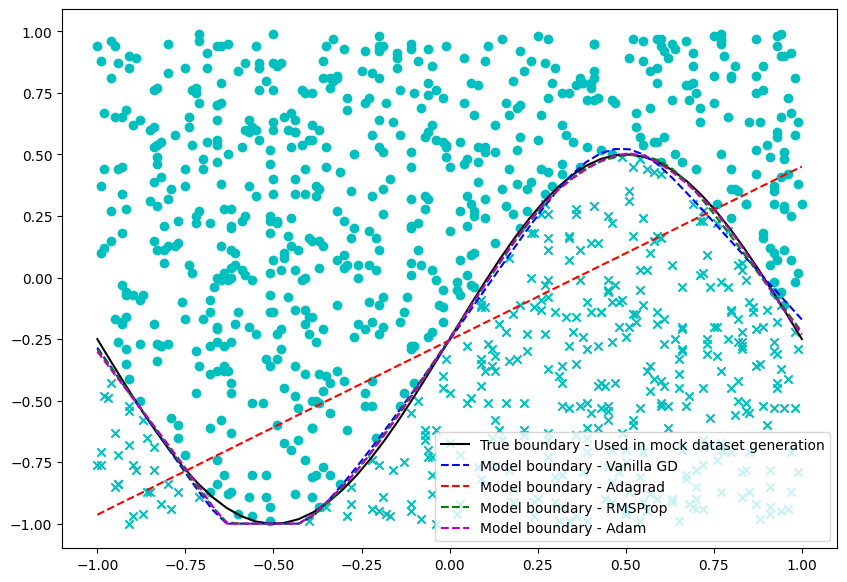

In [76]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - Used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_vanilla = [find_v2(v1, shallow_neural_net_vanilla, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_vanilla, "b--", label = "Model boundary - Vanilla GD")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adagrad = [find_v2(v1, shallow_neural_net_adagrad, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adagrad, "r--", label = "Model boundary - Adagrad")

# Display model boundary (sigmoid model, RMSProp GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_rmsprop = [find_v2(v1, shallow_neural_net_rmsprop, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_rmsprop, "g--", label = "Model boundary - RMSProp")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adam = [find_v2(v1, shallow_neural_net_adam, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adam, "m--", label = "Model boundary - Adam")

# Show
plt.legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate some additional variations on these optimizers, along with the mini-batch optimization procedure.